# Part 2: SCR Gradient Upper Bound Selection

To select the SCR gradient upper bound (UB), we select a UB value and assign offers, either the best offer if the gradient is above the UB, or the second best offer if the gradient is below the UB. We store the score metrics for this UB value. We then repeat the process for a range of UB and visualise the changes in metrics as a function of UB.

In [3]:
import os, sys, importlib
import pandas as pd
import numpy as np
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '/home/jovyan/a01_repos')
# import wx_tools.Wx_Utils as utl
# importlib.reload(sys.modules['Wx_Utils'])

sys.path.insert(0, '/home/jovyan/a01_repos/joe_utils')
# import joe_utils.UDF_Visualisation as viz

# Project specific user-defined functions
import utl_scr_opt as udf
importlib.reload(sys.modules['utl_scr_opt'])

sns.set_palette(sns.color_palette("muted", 10))

ModuleNotFoundError: No module named 'plotly'

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Prep

In [3]:
# Load data
scored_top2 = pd.read_parquet('data/scored_top2.parquet')
scored_top2.shape
scored_top2.tail(2)

(11208, 38)

crn  offerId hurdle_cat reward_cat campaign_type  \
11206  3300000000002655674  -177579          L          H            ss   
11207  3300000000002655674  -177578          L          M            ss   

      campaign_level campaign_category campaign_duration  camp_dur_wks cvm  \
11206          store                na                11          11.0  1T   
11207          store                na                11          11.0  1T   

       ...  inc_sales_diff_perc  target_cost_diff  target_cost_diff_perc  \
11206  ...             0.000000           0.00000               0.000000   
11207  ...            -4.122585          -0.19944             -36.438198   

       scr_gradient        scr  scr_diff  scr_diff_perc  score_diff  \
11206           NaN   6.801918  0.000000       0.000000     0.00000   
11207      0.769563  10.260097  3.458179      50.841236    -0.01519   

       score_diff_perc  rank  
11206         0.000000     1  
11207        -1.521878     2  

[2 rows x 38 columns]

In [4]:
cols = [
    'crn', 'offerId',
    'rank', 'score', 'inc_sales', 'target_cost',
    'scr', 'scr_gradient', 'inc_sales_diff', 'target_cost_diff',
]
scored_top2[cols].head()

crn  offerId  rank     score  inc_sales  target_cost  \
0  1000000000000000123       na     1  1.000000   0.000000     0.000000   
1  1000000000000000123  -151044     2  0.950000  -0.948526     0.089242   
2  1000000000000005953  -177547     1  0.999020   2.110014     1.352413   
3  1000000000000005953  -177546     2  0.981373   2.059573     1.155072   
4  1000000000000007310  -151129     1  0.957143   0.487251     0.000000   

         scr  scr_gradient  inc_sales_diff  target_cost_diff  
0        NaN           NaN        0.000000          0.000000  
1 -10.628664    -10.628664       -0.948526          0.089242  
2   1.560185           NaN        0.000000          0.000000  
3   1.783068      0.255606       -0.050442         -0.197341  
4        inf           NaN        0.000000          0.000000

In [5]:
scored_top2[cols].describe().round(2)

rank     score  inc_sales  target_cost      scr  scr_gradient  \
count  11208.0  11208.00   11208.00     11208.00  9795.00       5604.00   
mean       1.5      0.97       1.18         0.43      NaN           NaN   
std        0.5      0.03       3.08         0.80      NaN           NaN   
min        1.0      0.80     -35.52         0.00     -inf          -inf   
25%        1.0      0.97       0.00         0.01     1.66         -4.27   
50%        1.5      0.98       0.33         0.11     4.06          0.06   
75%        2.0      0.99       1.53         0.50     8.40          0.58   
max        2.0      1.00      32.88        10.12      inf           inf   

       inc_sales_diff  target_cost_diff  
count        11208.00          11208.00  
mean            -0.23             -0.00  
std              1.35              0.37  
min            -35.52             -4.85  
25%             -0.06             -0.00  
50%              0.00              0.00  
75%              0.00              0.00  
max             10.32              7.87

In [6]:
scored_top2[cols].groupby('rank')['scr'].describe().round(2)

count  mean  std  min   25%   50%   75%  max
rank                                               
1     4244.0   inf  NaN  0.0  2.57  4.24  8.36  inf
2     5551.0   NaN  NaN -inf  0.21  3.86  8.41  inf

In [7]:
cond = ~scored_top2['rank'].isnull()
scored_top2.loc[cond,'scr'].describe().round(2)

count    9795.00
mean         NaN
std          NaN
min         -inf
25%         1.66
50%         4.06
75%         8.40
max          inf
Name: scr, dtype: float64

In [8]:
# Best offer
scored_best = pd.read_parquet('data/decision_model_999.parquet')

# Missing crns in best offer were assigned to random group
crn_missing = list(set(scored_top2['crn']) - set(scored_best['crn']))
len(crn_missing)

# View sample of misisng crns
cond = scored_top2['crn'].isin(crn_missing)
# scored_top2[cond].head()

# Analysis without missing crn
scored_top2 = scored_top2[~cond]
scored_top2.shape
scored_top2['crn'].nunique()

560

(10088, 38)

5044

In [9]:
# SCR gradient UB
SCR_GRADIENT_UB = 1

## Scripting

## Enumerate over SCR Gradient UB

In [10]:
InteractiveShell.ast_node_interactivity = "all"

In [11]:
n = 30
n_zoom = 20
scr_gradient_ub_ls = np.linspace(-0.25, 3.5, n)
scr_zoom_ls = np.linspace(0.5, 1.5, n_zoom)
scr_gradient_ub_ls = np.concatenate((scr_gradient_ub_ls, scr_zoom_ls))
# scr_gradient_ub_ls

info_cols = ['scr_gradient_ub', 'crn', 'rank']
metric_cols = [
    'score', 'inc_sales', 'target_cost', 'scr',
    'inc_sales_diff', 'target_cost_diff', 'scr_diff', 'score_diff',
    'inc_sales_diff_perc', 'target_cost_diff_perc', 'scr_diff_perc', 'score_diff_perc',
]
enum_cols = info_cols + metric_cols

df_enum = pd.DataFrame(columns=enum_cols)

for ub in scr_gradient_ub_ls:
    scored_sel = udf.choose_offer(scored_top2, ub)
    scored_sel['scr_gradient_ub'] = ub
    df_enum = pd.concat((df_enum, scored_sel[enum_cols]), axis=0)
    
df_enum.shape
df_enum.head(2)
# df_enum.groupby(['scr_gradient_ub', 'rank']).size()

(252200, 15)

scr_gradient_ub                  crn rank    score  inc_sales  target_cost  \
0            -0.25  1000000000000000123    1  1.00000   0.000000     0.000000   
2            -0.25  1000000000000005953    1  0.99902   2.110014     1.352413   

        scr  inc_sales_diff  target_cost_diff  scr_diff  score_diff  \
0       NaN             0.0               0.0       NaN         0.0   
2  1.560185             0.0               0.0       0.0         0.0   

   inc_sales_diff_perc  target_cost_diff_perc  scr_diff_perc  score_diff_perc  
0                  NaN                    NaN            NaN              0.0  
2                  0.0                    0.0            0.0              0.0

In [12]:
# Check scr stats
cond = df_enum['scr_gradient_ub'] < 0
df_enum[cond].groupby(['scr_gradient_ub', 'rank']).agg({
    'rank': 'count',
    'scr': ['mean', 'median'],
})

rank        scr          
                     count       mean    median
scr_gradient_ub rank                           
-0.25000        1     4926        inf  4.214679
                2      118  12.029892  8.039750
-0.12069        1     4899        inf  4.228016
                2      145  11.979322  7.862062

In [13]:
# Replace scr == inf with na
df_enum.replace([np.inf, -np.inf], 100, inplace=True)
# df_enum.replace([np.inf, -np.inf], np.nan, inplace=True)

In [14]:
cond = df_enum['scr'].isnull()
df_enum[cond].shape
df_enum[cond].head()

(64509, 15)

scr_gradient_ub                  crn  rank  score  inc_sales  target_cost  \
0             -0.25  1000000000000000123     1    1.0        0.0          0.0   
10            -0.25  1000000000000029601     1    1.0        0.0          0.0   
20            -0.25  1000000000000101719     1    1.0        0.0          0.0   
22            -0.25  1000000000000102613     1    1.0        0.0          0.0   
26            -0.25  1000000000000106759     1    1.0        0.0          0.0   

    scr  inc_sales_diff  target_cost_diff  scr_diff  score_diff  \
0   NaN             0.0               0.0       NaN         0.0   
10  NaN             0.0               0.0       NaN         0.0   
20  NaN             0.0               0.0       NaN         0.0   
22  NaN             0.0               0.0       NaN         0.0   
26  NaN             0.0               0.0       NaN         0.0   

    inc_sales_diff_perc  target_cost_diff_perc  scr_diff_perc  score_diff_perc  
0                   NaN                    NaN            NaN              0.0  
10                  NaN                    NaN            NaN              0.0  
20                  NaN                    NaN            NaN              0.0  
22                  NaN                    NaN            NaN              0.0  
26                  NaN                    NaN            NaN              0.0

## Prep Visualise Data

In [15]:
# Unpivot metrics into a column
metric_cols = ['score', 'inc_sales', 'target_cost', 'scr']
enum_cols = info_cols + metric_cols

df_pvt = pd.melt(df_enum[enum_cols], id_vars=info_cols, value_vars=metric_cols,
                  var_name='metric', value_name='value')
df_pvt.head(2)

scr_gradient_ub                  crn  rank metric    value
0            -0.25  1000000000000000123     1  score  1.00000
1            -0.25  1000000000000005953     1  score  0.99902

## Visualise

In [16]:
InteractiveShell.ast_node_interactivity = "last"

In [17]:
# fig, ax = plt.subplots()
# # fig, ax = plt.subplots(1,2, figsize=(15,6))
# sns.lineplot(data=df_pvt, x='scr_gradient_ub', y='value', hue='metric')
# ax.axvline(x=0, c='k', ls='--')
# ax.set_title('Metrics by SCR Gradient UB')
# plt.show()

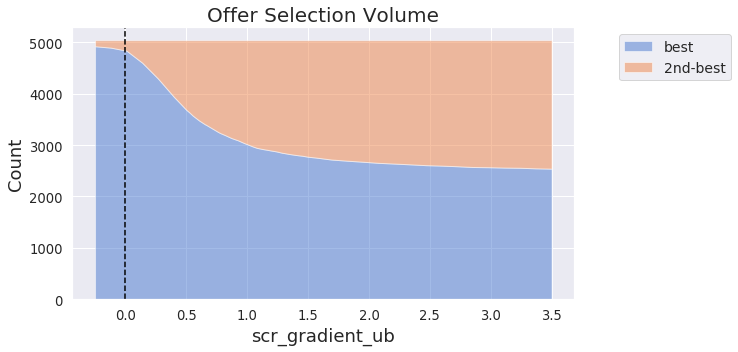

In [22]:
# crn volume: best vs 2nd best
df_plot = df_enum.groupby(['scr_gradient_ub', 'rank']).size().to_frame('count').reset_index()
mycolors = ['tab:orange', 'tab:blue']
x = df_plot['scr_gradient_ub'].unique()

cond = df_plot['rank'] == 1
y1 = df_plot.loc[cond,'count']
cond = df_plot['rank'] == 2
y2 = df_plot.loc[cond,'count']
y = np.vstack([y1, y2])

# plot
fig, ax = plt.subplots()
ax.stackplot(x, y, labels=['best', '2nd-best'], alpha=0.5)
# ax.stackplot(x, y, labels=['best', '2nd-best'], colors=mycolors, alpha=0.5)
ax.axvline(x=0, c='k', ls='--')
ax.set_title('Offer Selection Volume')
ax.set_xlabel('scr_gradient_ub')
ax.set_ylabel('Count')
ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1))
plt.show()

### Multi-plot

In [23]:
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.35   # the amount of height reserved for white space between subplots # 0.2

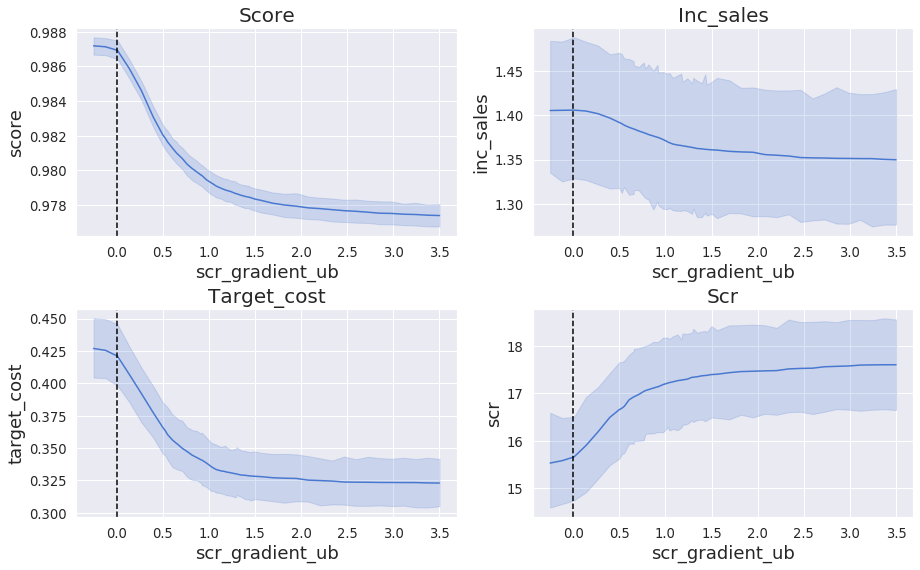

In [24]:
fig=udf.plot_metrics_tile(df_enum)

### Dual axis plots

In [25]:
# Dual axis plots
# metric_cols = ['inc_sales', 'scr', 'target_cost', 'score']
# enum_cols = info_cols + metric_cols
# df_plot_long = df_enum[enum_cols]#.sample(1000)
# df_plot_long.shape

df_plot_long = df_enum#.sample(100)

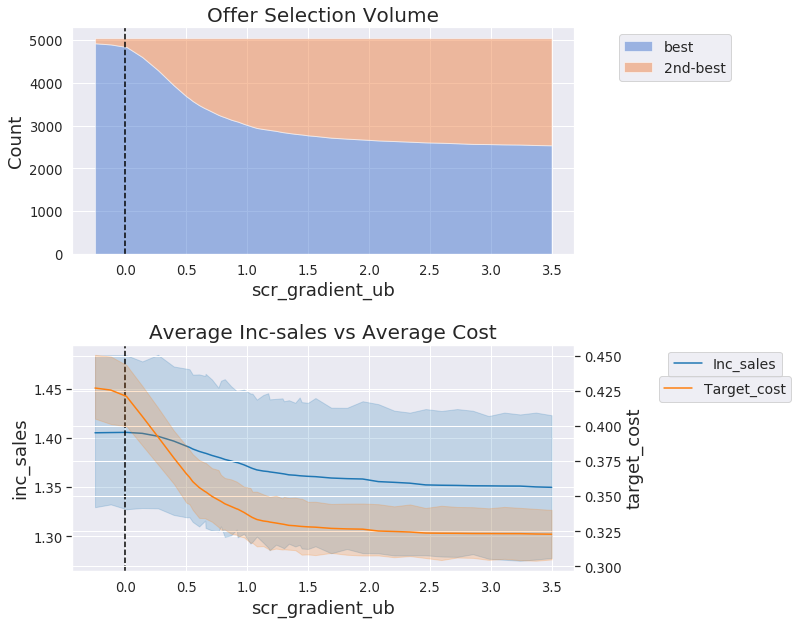

In [29]:
fig, ax = plt.subplots(2,1, figsize=(9,10))
fig.subplots_adjust(hspace=0.4) # the amount of height reserved for white space between subplots # 0.2

# -------------------------------------------------
# offer volume plot
# -------------------------------------------------
ax[0].stackplot(x, y, labels=['best', '2nd-best'], alpha=0.5)
ax[0].axvline(x=0, c='k', ls='--')
ax[0].set_title('Offer Selection Volume')
ax[0].set_xlabel('scr_gradient_ub')
ax[0].set_ylabel('Count')
ax[0].legend(loc='upper center', bbox_to_anchor=(1.2, 1))

# -------------------------------------------------
# inc-sales vs cost
# -------------------------------------------------
f=udf.plot_dual_metrics(df_plot_long, x='scr_gradient_ub', y1='inc_sales', y2='target_cost', 
                        fig=fig, ax=ax[1], title='Average Inc-sales vs Average Cost')

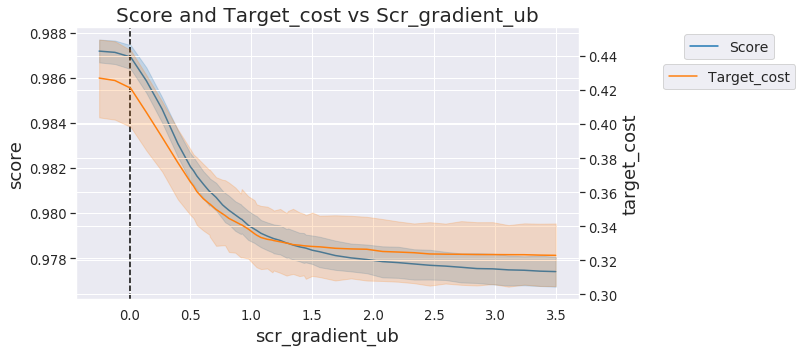

In [27]:
fig=udf.plot_dual_metrics(df_enum, x='scr_gradient_ub', y1='score', y2='target_cost')

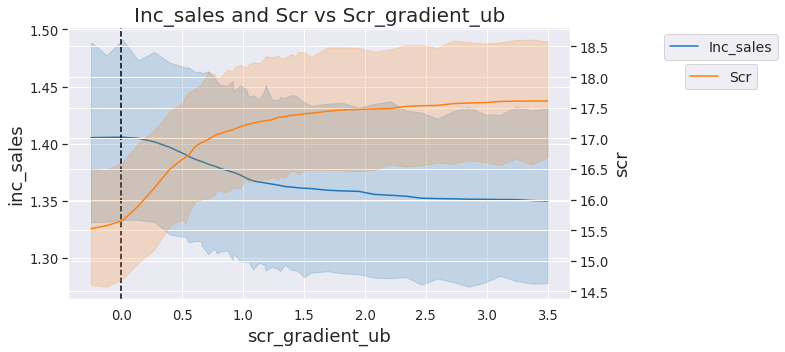

In [28]:
fig=udf.plot_dual_metrics(df_enum, x='scr_gradient_ub', y1='inc_sales', y2='scr')

### Metrics Diff
Metrics Diff shows the change in metric value from choosing the 2nd best offer instead of the best offer. For example, a negative Inc-sales Diff represents a decrease in Inc-sales when choosing the 2nd best instead of the best.

In [149]:
cond = df_enum['scr_gradient_ub'] < 0
df_enum[cond].groupby(['scr_gradient_ub','rank'])['inc_sales_diff'].describe().round(2)

count  mean   std  min   25%   50%   75%   max
scr_gradient_ub rank                                                 
-0.500000       1     4961.0  0.00  0.00  0.0  0.00  0.00  0.00  0.00
                2       83.0  0.12  0.26  0.0  0.01  0.04  0.11  1.91
-0.379310       1     4948.0  0.00  0.00  0.0  0.00  0.00  0.00  0.00
                2       96.0  0.12  0.25  0.0  0.01  0.04  0.11  1.91
-0.258621       1     4927.0  0.00  0.00  0.0  0.00  0.00  0.00  0.00
                2      117.0  0.11  0.23  0.0  0.01  0.04  0.11  1.91
-0.137931       1     4904.0  0.00  0.00  0.0  0.00  0.00  0.00  0.00
                2      140.0  0.10  0.21  0.0  0.01  0.04  0.10  1.91
-0.017241       1     4862.0  0.00  0.00  0.0  0.00  0.00  0.00  0.00
                2      182.0  0.08  0.19  0.0  0.00  0.03  0.09  1.91

In [150]:
df_enum[cond].groupby(['scr_gradient_ub'])['inc_sales_diff'].describe().round(2)

count  mean   std  min  25%  50%  75%   max
scr_gradient_ub                                              
-0.500000        5044.0   0.0  0.04  0.0  0.0  0.0  0.0  1.91
-0.379310        5044.0   0.0  0.04  0.0  0.0  0.0  0.0  1.91
-0.258621        5044.0   0.0  0.04  0.0  0.0  0.0  0.0  1.91
-0.137931        5044.0   0.0  0.04  0.0  0.0  0.0  0.0  1.91
-0.017241        5044.0   0.0  0.04  0.0  0.0  0.0  0.0  1.91

In [151]:
cond = df_enum['rank'] == 2
df_plot_diff = df_enum[cond]
df_plot_diff.shape

(75474, 15)

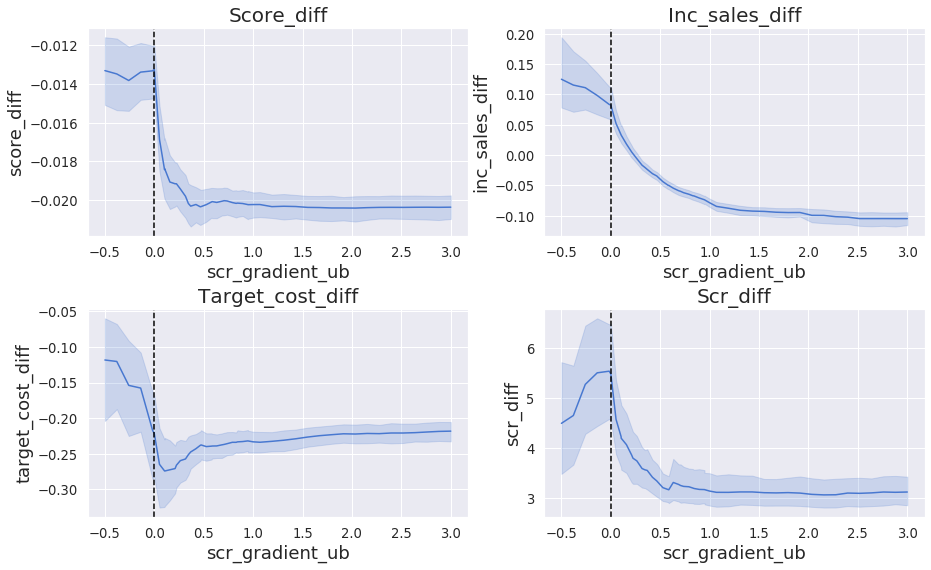

In [152]:
fig=udf.plot_metrics_tile(df_plot_diff, is_diff=True)

### Dual Plots

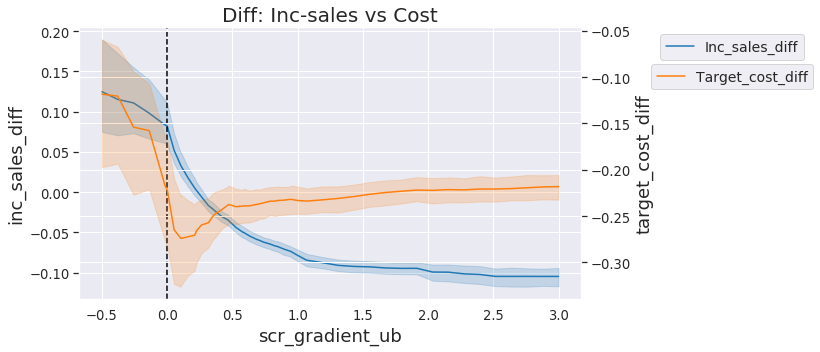

In [153]:
fig=udf.plot_dual_metrics(df_plot_diff, x='scr_gradient_ub', y1='inc_sales_diff', y2='target_cost_diff',
                         title='Diff: Inc-sales vs Cost')

## SCR Optimisation (Brute Force)
The plots above suggest we should select the SCR gradient UB that maximises inc-sales and minimises cost. We select this *crossover* point by normalising inc-sales and cost, and summing these values (inverted cost).

In [61]:
InteractiveShell.ast_node_interactivity = "all"

In [62]:
from sklearn.preprocessing import MinMaxScaler
sclr = MinMaxScaler()

scl_cols = ['inc_sales', 'target_cost', 'score']

In [63]:
# Get mean of metrics
df_enum_mean = df_enum.groupby(['scr_gradient_ub'])[scl_cols].mean().reset_index()
df_enum_mean.shape

(50, 4)

In [64]:
# Scale
df_scl = pd.DataFrame(
    sclr.fit_transform(df_enum_mean[scl_cols]),
    columns=scl_cols,
    index=df_enum_mean.index,
)
df_enum_mean_scl = pd.concat((df_enum_mean['scr_gradient_ub'], df_scl), axis=1, sort=False)

In [65]:
# Don't scale
df_enum_mean_scl = df_enum_mean.copy()

In [66]:
# Invert {target_cost} (to maximise)
stats = df_enum_mean_scl['target_cost'].describe()
df_enum_mean_scl['target_cost'] = -df_enum_mean_scl['target_cost'] + stats['min'] + stats['max']

# Add scaled metrics (to maximise)
df_enum_mean_scl['inc_sales_cost'] = df_enum_mean_scl['inc_sales'] + df_enum_mean_scl['target_cost']
df_enum_mean_scl['score_cost'] = df_enum_mean_scl['score'] + df_enum_mean_scl['target_cost']

In [72]:
# Crossover point
inc_sales_cost_argmax = df_enum_mean_scl['inc_sales_cost'].idxmax()
inc_sales_cost_max = df_enum_mean_scl['inc_sales_cost'].max()
inc_sales_cost_scr_gradient_ub = df_enum_mean_scl.loc[inc_sales_cost_argmax, 'scr_gradient_ub']
print(f'inc_sales_cost crossover: {inc_sales_cost_argmax}, {inc_sales_cost_max}, {inc_sales_cost_scr_gradient_ub}')

score_cost_argmax = df_enum_mean_scl['score_cost'].idxmax()
score_cost_max = df_enum_mean_scl['score_cost'].max()
score_cost_scr_gradient_ub = df_enum_mean_scl.loc[score_cost_argmax, 'scr_gradient_ub']
print(f'score_cost crossover: {score_cost_argmax}, {score_cost_max}, {score_cost_scr_gradient_ub}')

inc_sales_cost crossover: 23, 1.7862002849578857, 1.026315789473684
score_cost crossover: 49, 1.4060677575448213, 3.0


### Total Inc-sales and Total Cost
Get the total (population) inc-sales and cost for each SCR gradient UB. Then calculate the delta inc-sales and cost from the baseline of best offers, and calculate the net position (delta inc-sales + delta cost).

In [73]:
# Get total
df_enum_total = df_enum.groupby(['scr_gradient_ub'])[scl_cols].sum().reset_index()

# Get baseline total inc-sales and cost
scored_best_total = scored_best[['inc_sales', 'target_cost']].sum()
scored_best_total

# Delta
df_enum_total['inc_sales_delta'] = df_enum_total['inc_sales'] - scored_best_total['inc_sales']
df_enum_total['target_cost_delta'] = df_enum_total['target_cost'] - scored_best_total['target_cost']
df_enum_total['inc_sales_cost_net'] = df_enum_total['inc_sales_delta'] - df_enum_total['target_cost_delta'] 
df_enum_total.head(2)

scr_gradient_ub    inc_sales  target_cost        score  inc_sales_delta  \
0         -0.50000  7085.630859  2161.617432  4979.921754        10.349609   
1         -0.37931  7086.330566  2159.877930  4979.732188        11.049316   

   target_cost_delta  inc_sales_cost_net  
0          -9.820801           20.170410  
1         -11.560303           22.609619

### Visualise

In [74]:
InteractiveShell.ast_node_interactivity = "last"

### Inc-sales and cost

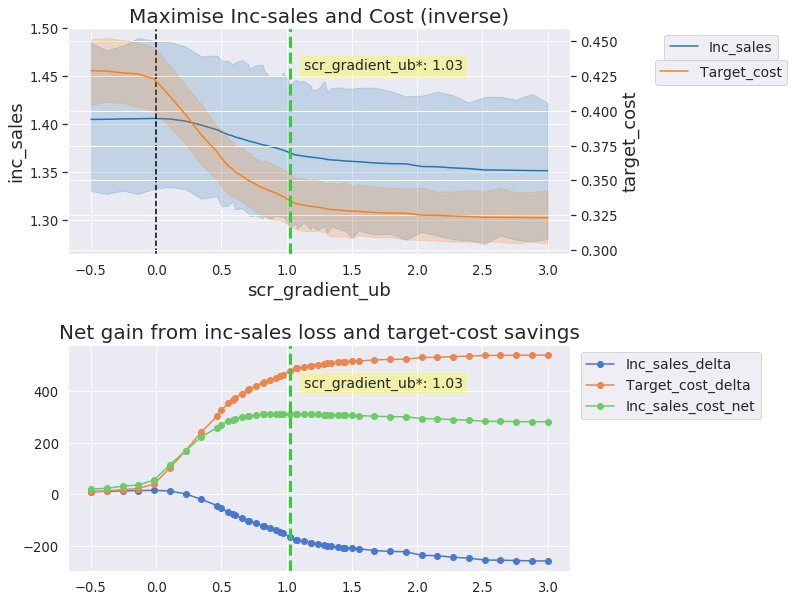

In [82]:
fig, ax = plt.subplots(2,1, figsize=(9,10))
fig.subplots_adjust(hspace=0.4) # the amount of height reserved for white space between subplots # 0.2

# Original
df_plot = df_enum.copy()
f=udf.plot_dual_metrics(df_plot, x='scr_gradient_ub', y1='inc_sales', y2='target_cost', 
                        x_opt=inc_sales_cost_scr_gradient_ub,
                        title='Maximise Inc-sales and Cost (inverse)',
                        fig=fig, ax=ax[0])

# Net gain from inc-sales loss and target-cost reduction
df_plot = df_enum_total.copy()
df_plot['target_cost_delta'] = -df_plot['target_cost_delta']

f=udf.plot_multi_metrics(df_plot, x='scr_gradient_ub',
                      metric_ls=['inc_sales_delta', 'target_cost_delta', 'inc_sales_cost_net'],
                      title='Net gain from inc-sales loss and target-cost savings',
                      fig=fig, ax=ax[1],
                      x_opt=inc_sales_cost_scr_gradient_ub)

### Score and Cost

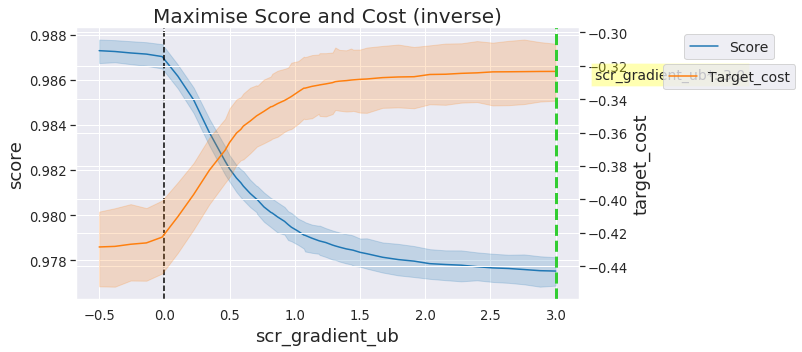

In [81]:
df_plot = df_enum.copy()
df_plot['target_cost'] = -df_plot['target_cost']

f=udf.plot_dual_metrics(df_plot, x='scr_gradient_ub', y1='score', y2='target_cost', 
                        title='Maximise Score and Cost (inverse)',
                        x_opt=score_cost_scr_gradient_ub,)